## Torch Geometric & openTSNE 설치

In [ ]:
import torch

!pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
!pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git
!pip install openTSNE

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:

from scipy.special import comb, logsumexp
import numpy as np
import networkx as nx
from sklearn.model_selection import train_test_split

import torch
import torch.nn.functional as F

import torch_geometric as pyg
from torch_geometric.nn import GCNConv, GAE
from torch_geometric.utils import negative_sampling

import matplotlib.pyplot as plt
%matplotlib inline

## 데이터 다운로드 후 불러오기


Stanford Biomedical Network Dataset Collection (ChCh-Miner)에서 drug interaction 데이터 다운받기

In [ ]:
!mkdir -p data
!wget http://snap.stanford.edu/biodata/datasets/10001/files/ChCh-Miner_durgbank-chem-chem.tsv.gz -O data/ChCh-Miner_durgbank-chem-chem.tsv.gz
!yes | gunzip data/ChCh-Miner_durgbank-chem-chem.tsv.gz

--2022-11-13 07:29:01--  http://snap.stanford.edu/biodata/datasets/10001/files/ChCh-Miner_durgbank-chem-chem.tsv.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 206802 (202K) [application/x-gzip]
Saving to: ‘data/ChCh-Miner_durgbank-chem-chem.tsv.gz’

data/ChCh-Miner_dur 100%[===================>] 201.96K   658KB/s    in 0.3s    

2022-11-13 07:29:02 (658 KB/s) - ‘data/ChCh-Miner_durgbank-chem-chem.tsv.gz’ saved [206802/206802]

gzip: data/ChCh-Miner_durgbank-chem-chem.tsv already exists;	not overwritten


In [ ]:
!head data/ChCh-Miner_durgbank-chem-chem.tsv

DB00862	DB00966
DB00575	DB00806
DB01242	DB08893
DB01151	DB08883
DB01235	DB01275
DB00018	DB00333
DB00201	DB01609
DB00712	DB01418
DB01576	DB04842
DB01609	DB06212


**Drug ID에 정수 인덱스 매핑 시키기**
torch_geometric에서 graph 데이터를 활용하려면 edge list는 node indices로 표현되어야 한다.
다운받은 데이터는 Drug 이름으로 되어있기 때문에 각 노드를 정수 값의 index로 매핑시킨 뒤 정수 index를 가진 edgelist를 만든다.


**drug_dict** \\
DB00862:0 \\
DB00575:1 \\

**edge_index** \\
[[0,1]
[2,3]
...]


In [ ]:
drug_dict, edge_index = {}, [] 
# drug_dict - Drug name : Drug Index
# edge_index - [[node1, node2], ... ]

drug_index = 0  # 각 drug에 부여할 인덱스

with open("data/ChCh-Miner_durgbank-chem-chem.tsv") as f:
    for line in f:
        line = line.rstrip()
        d1, d2 = line.split("\t")
        
        if d1 not in drug_dict:
            drug_dict[d1] = drug_index
            drug_index += 1
        if d2 not in drug_dict:
            drug_dict[d2] = drug_index
            drug_index += 1
        
        edge_index.append([drug_dict[d1], drug_dict[d2]])

print(f"{len(edge_index):,} interactions")

48,514 interactions


In [ ]:
# edge index를 Tenosor로 만든 뒤 (2 x number of interaction) 형태로 transpose
edge_index = torch.LongTensor(edge_index).T 

We now has something that _torch_geometric_ considers a graph.

### graph 살펴보기

In [ ]:
edge_index.shape

torch.Size([2, 48514])

In [ ]:
# graph sparsity 확인 
print("Sparsity: %.2f" % (edge_index.size(1) / comb(len(edge_index[0].unique()), 2)))

Sparsity: 0.06


In [ ]:
pyg.utils.is_undirected(edge_index)

False

<!-- Even though the graph is undirected, we're going to cast it to a directed graph, so this will be one less piece of complexity we will have to worry about. -->

실제 그래프는 directed 지만, undirected로 취급하여 실습을 진행

In [ ]:
edge_index = pyg.utils.to_undirected(edge_index)

In [ ]:
print(f"{len(edge_index.unique()):,} nodes")

1,514 nodes


### Extract LCC

diconnected graph는 연산을 적용하기 어렵기 때문에, largest connected component (LCC)을 만들어 이 후 GAT를 적용한다.

(LCC를 만들기 위해 파이썬 라이브러리인 networkx를 사용)

<!-- 
Many graph-based learning techniques cannot operate on disconnected graphs, so it is standard practice to operate on the largest connected component (LCC). The easiest way to exctract the LCC is to use _networkx_, a popular pure Python library for network analysis. -->

In [ ]:
data = pyg.data.Data(edge_index=edge_index)
nx_data = pyg.utils.to_networkx(data, to_undirected=True)
nx_data

/usr/local/lib/python3.7/dist-packages/torch_geometric/data/storage.py:276: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'edge_index'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  " to suppress this warning")


In [ ]:
connected_components = list(nx.connected_components(nx_data))
print(f"Graph contains {len(connected_components)} connected components")

Graph contains 3 connected components


In [ ]:
lcc_nodes = max(connected_components, key=len)
lcc = nx_data.subgraph(lcc_nodes)
print(f"{lcc.number_of_nodes():,} nodes in LCC")

1,510 nodes in LCC


We've now extracted the LCC of our graph and lost 4 nodes. Let's convert this back into a torch edge list, so we can start fitting our models.

In [ ]:
edge_index = pyg.utils.from_networkx(lcc).edge_index
edge_index

tensor([[   0,    0,    0,  ..., 1507, 1508, 1509],
        [   1,    2,    9,  ..., 1011,  346,   45]])

## Prepare data set

일반적인 머신러닝 테스크와 같이, 데이터를 training set과 validation set으로 나누어서 진행한다. \\
torch_geometric에서 이를 구현하기 가장 쉬운 방법은 boolean mask를 정의하는 것이다. \\
(edge_list와 크기가 같은 boolean mask를 통해 train, validation 구분) \\
(pyg.data.Data 의 train_mask, val_mask 파라미터에 입력해주면 됨)

<!-- As in any machine learning task, we split our data set into a training and validation set. In _torch_geometric_, it is easiest to define boolean masks to indicate which edges belong into each set. Why not use integer indices? Because we can easily attach boolean masks to a _torch_geometric_ `pyg.data.Data` object, which will be indexed properly during mini-batching. Indexing the masks is only possible if their shape matches that of the `edge_index`, so a boolean mask is the way to go. -->

In [ ]:
indices = torch.arange(edge_index.shape[1])
train_idx, val_idx = train_test_split(indices, test_size=0.01)
train_mask, val_mask = torch.zeros_like(indices).bool(), torch.zeros_like(indices).bool()
train_mask[train_idx] = 1
val_mask[val_idx] = 1
train_mask, val_mask

(tensor([True, True, True,  ..., True, True, True]),
 tensor([False, False, False,  ..., False, False, False]))

**Node feature random initialization** \\


일반적으로 node feature는 one-hot encoding으로 진행하기도 하지만 \\
노드 개수 만큼의 dense identity matrix를 만들어야 하기 때문에, 메모리적으로 비효율 적일 뿐 아니라 \\
torch_geometric이 아직 sparse matrics를 완전히 지원하지 않으므로 \\
여기서는 임의의 차원의 랜덤 값을 초기 node feature로 사용



In [ ]:
data = pyg.data.Data(edge_index=edge_index, train_mask=train_mask, val_mask=val_mask)
data.x = torch.randn(data.num_nodes, 128)
data

/usr/local/lib/python3.7/dist-packages/torch_geometric/data/storage.py:276: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'train_mask', 'val_mask', 'edge_index'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  " to suppress this warning")


Data(edge_index=[2, 97024], train_mask=[97024], val_mask=[97024], x=[1510, 128])

## Attention mechanism

We will first see how to propagate information for a single node. This is easily done using an edge list, which we can easily obtain by using the CSR format of sparse matrices.

In [ ]:
import torch_sparse

In [ ]:
adj = torch_sparse.SparseTensor(row=edge_index[0], col=edge_index[1])
indptr, indices, _ = adj.csr()
indptr, indices

(tensor([    0,   133,   181,  ..., 97022, 97023, 97024]),
 tensor([   1,    2,    9,  ..., 1011,  346,   45]))

In [ ]:
# 임의의 node 하나 정하기 
node_idx = 1371

# 해당 노드의 neighbor nodes
neighbors = indices[indptr[node_idx] : indptr[node_idx + 1]]
neighbors

tensor([ 378,  412,  876, 1370, 1391])

### 하나의 노드에서 attention mechanism 진행



In [ ]:
x = data.x
edge_index = data.edge_index

Let's start by defining a few variables that will help us later on. For the out dimension, we'll arbitrarily choose 16.

In [ ]:
in_features = x.shape[1] # 처음 initialization한 차원 값 (128)
out_features = 16 # GAT 레이어 이후 차원 값 

In [ ]:
weight = torch.Tensor(torch.rand(in_features, out_features))
bias = torch.Tensor(torch.rand(1))

In [ ]:
# Split the attention vector for efficiency
att_l = torch.Tensor(torch.rand(1, out_features))
att_r = torch.Tensor(torch.rand(1, out_features))

In [ ]:
x_lin = x @ weight
x_lin.shape

torch.Size([1510, 16])

neigbor node의 attention coefficient

In [ ]:
alpha_l = torch.sum(x_lin[neighbors] * att_r, dim=1)
alpha_l

tensor([ 59.2302,  12.6048,  23.7053,  26.4433, -30.8054])

중심 node의 attention coefficient

In [ ]:
alpha_r = torch.sum(x_lin[node_idx] * att_r, dim=1)
alpha_r

tensor([-15.8546])

최정 unnormalized $\alpha$ coefficients을 구하기 위해 두 $\alpha$ 를 더한다.

In [ ]:
alpha = alpha_l + alpha_r
alpha

tensor([ 43.3756,  -3.2498,   7.8507,  10.5887, -46.6600])

In [ ]:
alpha = F.leaky_relu(alpha, negative_slope=0.2)
alpha

tensor([43.3756, -0.6500,  7.8507, 10.5887, -9.3320])

Attention update는 neighbor node의 가중합을 통해 aggregation을 진행함으로 \\
softmax 연산을 통해 합이 1인 attention coefficient의 합이 1로 만들어 준다.

In [ ]:
alpha = F.softmax(alpha, dim=0)
alpha

tensor([1.0000e+00, 7.5844e-20, 3.7300e-16, 5.7651e-15, 1.2864e-23])

Attention update 진행

In [ ]:
Z = torch.sum(alpha.unsqueeze(-1) * x_lin[neighbors], dim=0)
Z += bias
Z

tensor([ 2.9779, 12.5093, 11.7018,  5.5235,  7.6071, 15.9968,  4.1422,  8.3898,
         5.4882,  5.4027,  3.0602,  8.4533,  9.6360, 12.8766, 10.8739, 12.2872])

In [ ]:
Z = F.relu(Z)
Z

tensor([ 2.9779, 12.5093, 11.7018,  5.5235,  7.6071, 15.9968,  4.1422,  8.3898,
         5.4882,  5.4027,  3.0602,  8.4533,  9.6360, 12.8766, 10.8739, 12.2872])

노드 하나에 대한 attention update 완료

### 모든 node에 대해 attention update 진행



In [ ]:
x = data.x
edge_index = data.edge_index

In [ ]:
in_features = x.shape[1]
out_features = 16

In [ ]:
weight = torch.Tensor(torch.rand(in_features, out_features))
bias = torch.Tensor(torch.rand(1))

In [ ]:
att_l = torch.Tensor(torch.rand(1, out_features))
att_r = torch.Tensor(torch.rand(1, out_features))

In [ ]:
x_lin = x @ weight
x_lin.shape

torch.Size([1510, 16])

모든 노드에 대해 (partial) attention coefficient 구하기

In [ ]:
alpha_l = torch.sum(x_lin * att_l, dim=1)
alpha_r = torch.sum(x_lin * att_r, dim=1)

 edge index를 이용해 source node와 target node 구해서
 최종 alpha 구하기

In [ ]:
alpha = alpha_l[edge_index[0]] + alpha_r[edge_index[1]]
alpha.shape

torch.Size([97024])

We see that we have as many coefficients as there are edges in our graph.

In [ ]:
alpha

tensor([-57.9566, -60.6239, -32.5006,  ..., -22.9453,  -2.6549,  21.2188])

In [ ]:
alpha = F.leaky_relu(alpha, negative_slope=0.2)
alpha

tensor([-11.5913, -12.1248,  -6.5001,  ...,  -4.5891,  -0.5310,  21.2188])

각 source node의 target node 별로 softmax 적용

torch_geometric의 softmax function에서 이를 지원한다.


In [ ]:
alpha = pyg.utils.softmax(alpha, edge_index[1])
alpha

tensor([6.1238e-15, 2.3270e-18, 8.7635e-24,  ..., 2.9392e-14, 6.1708e-16,
        1.4244e-26])

softmax가 잘 적용되었는지 확인해보기

In [ ]:
alpha[edge_index[1] == node_idx].sum()

tensor(1.)

source node에 attention coefficient 곱하기


In [ ]:
z_j = alpha.unsqueeze(-1) * x_lin[edge_index[0]]
z_j.shape

torch.Size([97024, 16])

최종 latent representation을 얻기 위해 aggregation 진행

각 노드에 대해 neighbor을 찾고, represention을 더하는 과정을 반복한다. \\
(여기서는 일단 for loop을 이용해 진행)

In [ ]:
Z = torch.zeros(data.num_nodes, z_j.shape[1])
for i, j in enumerate(edge_index[1]):
    Z[j] += z_j[i]
Z

tensor([[17.7022, 14.7869, 16.8493,  ..., 12.8040, 12.1093, 22.0086],
        [14.0444, 12.9136,  9.8404,  ..., 12.6402, 17.8948,  5.6037],
        [14.2783, 15.5012,  7.7397,  ..., 15.3744, 12.0081,  7.5853],
        ...,
        [ 1.7068, -2.2747, -2.6939,  ...,  2.6236, -7.1087, -4.4594],
        [ 3.7885,  3.9993, -5.3136,  ..., -2.2261, -3.8446, -1.2402],
        [ 0.3696, -0.3862,  5.5587,  ...,  5.9943,  4.4021,  6.1243]])

위에서와 같이 for loop 을 이용하면 구현은 간단하지만, 느리고 pythonic하지 않다. \\
이를 좀 더 효과적으로 구현하기 위해서는 torch_scatter를 사용하면 좋다. (GPU에서도 잘 작동함)

In [ ]:
import torch_scatter

In [ ]:
Z1 = torch_scatter.scatter(z_j, edge_index[1], dim=0, reduce="add")
Z1.shape

torch.Size([1510, 16])

In [ ]:
Z1

tensor([[17.7022, 14.7869, 16.8493,  ..., 12.8040, 12.1093, 22.0086],
        [14.0444, 12.9136,  9.8404,  ..., 12.6402, 17.8948,  5.6037],
        [14.2783, 15.5012,  7.7397,  ..., 15.3744, 12.0081,  7.5853],
        ...,
        [ 1.7068, -2.2747, -2.6939,  ...,  2.6236, -7.1087, -4.4594],
        [ 3.7885,  3.9993, -5.3136,  ..., -2.2261, -3.8446, -1.2402],
        [ 0.3696, -0.3862,  5.5587,  ...,  5.9943,  4.4021,  6.1243]])

for loop을 돌렸을 때와 결과는 완전히 같지만, 속도는 더 빠르다. 

In [ ]:
Z += bias
Z

tensor([[17.7879, 14.8726, 16.9350,  ..., 12.8896, 12.1950, 22.0942],
        [14.1301, 12.9993,  9.9260,  ..., 12.7259, 17.9805,  5.6893],
        [14.3640, 15.5869,  7.8253,  ..., 15.4600, 12.0938,  7.6709],
        ...,
        [ 1.7925, -2.1891, -2.6083,  ...,  2.7093, -7.0230, -4.3737],
        [ 3.8741,  4.0850, -5.2279,  ..., -2.1404, -3.7589, -1.1545],
        [ 0.4553, -0.3005,  5.6443,  ...,  6.0799,  4.4877,  6.2099]])

In [ ]:
Z = F.relu(Z)
Z

tensor([[17.7879, 14.8726, 16.9350,  ..., 12.8896, 12.1950, 22.0942],
        [14.1301, 12.9993,  9.9260,  ..., 12.7259, 17.9805,  5.6893],
        [14.3640, 15.5869,  7.8253,  ..., 15.4600, 12.0938,  7.6709],
        ...,
        [ 1.7925,  0.0000,  0.0000,  ...,  2.7093,  0.0000,  0.0000],
        [ 3.8741,  4.0850,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.4553,  0.0000,  5.6443,  ...,  6.0799,  4.4877,  6.2099]])

### torch_geometric으로 구현하기


torch geometric을 이용하면 위의 과정을 훨씬 쉽게 구현할 수 있다.


In [ ]:
class GATConv(pyg.nn.MessagePassing):
    def __init__(self):
        super().__init__(aggr="add", node_dim=0)
        self.weight = weight
        self.bias = bias
        self.att_l = att_l
        self.att_r = att_r
        
    def forward(self, x, edge_index):
        x_lin = x @ self.weight
        
        alpha_l = torch.sum(x_lin * self.att_l, dim=1)
        alpha_r = torch.sum(x_lin * self.att_r, dim=1)
        
        out = self.propagate(edge_index, x=x_lin, alpha=(alpha_l, alpha_r))
        # propagate는 pyg.nn.MessagePassing에서 상속 받은 함수
        # 자세한 내용은 아래 링크 참조
        # https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html
        
        out += self.bias
        
        return out
        
    def message(self, x_j, alpha_i, alpha_j, index):
        alpha = alpha_i + alpha_j
        alpha = F.leaky_relu(alpha, 0.2)
        alpha = pyg.utils.softmax(alpha, index)
        return alpha.unsqueeze(-1) * x_j
    
conv = GATConv()
F.relu(conv(x, edge_index))

tensor([[17.7879, 14.8726, 16.9350,  ..., 12.8896, 12.1950, 22.0942],
        [14.1301, 12.9993,  9.9260,  ..., 12.7259, 17.9805,  5.6893],
        [14.3640, 15.5869,  7.8253,  ..., 15.4600, 12.0938,  7.6709],
        ...,
        [ 1.7925,  0.0000,  0.0000,  ...,  2.7093,  0.0000,  0.0000],
        [ 3.8741,  4.0850,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.4553,  0.0000,  5.6443,  ...,  6.0799,  4.4877,  6.2099]])

위의 직접 계산한 결과와 완전히 같지만 훨씬 구현이 간단함

## Multi-head attention


여러 개의 attention "head"로 k개의 latent represention을 만든다. \\
전체적인 과정은 위에서와 동일함.

In [ ]:
x = data.x
edge_index = data.edge_index

In [ ]:
in_features = x.shape[1]
out_features = 16
k_heads = 3 # head 개수 정하기

In [ ]:
weight = torch.Tensor(torch.rand(in_features, k_heads * out_features))
bias = torch.Tensor(torch.rand(1, k_heads, 1))

In [ ]:
# 효율을 위해 attention 벡터 나누기
att_l = torch.Tensor(torch.rand(1, k_heads, out_features))
att_r = torch.Tensor(torch.rand(1, k_heads, out_features))
att_l.shape, att_r.shape

(torch.Size([1, 3, 16]), torch.Size([1, 3, 16]))

In [ ]:
x_lin = (x @ weight).view(-1, k_heads, out_features)
x_lin.shape

torch.Size([1510, 3, 16])

모든 노드에 대해 attention coefficient 구하기

In [ ]:
alpha_l = torch.sum(x_lin * att_l, dim=2)
alpha_r = torch.sum(x_lin * att_r, dim=2)
alpha_l.shape, alpha_r.shape

(torch.Size([1510, 3]), torch.Size([1510, 3]))

In [ ]:
alpha = alpha_l[edge_index[0]] + alpha_r[edge_index[1]]
alpha.shape

torch.Size([97024, 3])

In [ ]:
alpha

tensor([[-68.8653, -55.3361, -63.3982],
        [-71.1185, -69.5046, -61.6702],
        [-40.9709, -49.4100, -43.3094],
        ...,
        [-59.0810, -39.3037, -40.0573],
        [ 14.1447,   5.7871, -13.7623],
        [  6.5115,   1.1189,  12.1076]])

In [ ]:
alpha = F.leaky_relu(alpha, negative_slope=0.2)
alpha

tensor([[-13.7731, -11.0672, -12.6796],
        [-14.2237, -13.9009, -12.3340],
        [ -8.1942,  -9.8820,  -8.6619],
        ...,
        [-11.8162,  -7.8607,  -8.0115],
        [ 14.1447,   5.7871,  -2.7525],
        [  6.5115,   1.1189,  12.1076]])

In [ ]:
alpha = pyg.utils.softmax(alpha, edge_index[1])
alpha

tensor([[6.9342e-33, 4.1061e-41, 2.1511e-22],
        [4.1185e-36, 1.4560e-39, 5.2626e-30],
        [1.4111e-42, 3.5873e-43, 2.2547e-29],
        ...,
        [5.7788e-25, 5.5521e-32, 8.8559e-23],
        [1.5074e-23, 3.2791e-30, 1.1732e-22],
        [0.0000e+00, 0.0000e+00, 0.0000e+00]])

In [ ]:
alpha[edge_index[1] == node_idx, 0].sum()

tensor(1.)

In [ ]:
z_j = alpha.unsqueeze(-1) * x_lin[edge_index[0]]
z_j.shape

torch.Size([97024, 3, 16])

In [ ]:
Z = torch_scatter.scatter(z_j, edge_index[1], dim=0, reduce="add")
Z.shape

torch.Size([1510, 3, 16])

In [ ]:
Z += bias
Z = F.relu(Z)

In [ ]:
Z.shape

torch.Size([1510, 3, 16])

각 head 별로 16 차원의 feature vector가 존재함. \\
이 벡터들은 상황에 따라 concatentate 하거 average를 구한다. \\
여기서는 concatentate로 진행

In [ ]:
Z = Z.view(-1, k_heads * out_features)
Z

tensor([[ 5.8189,  4.1918, 16.9605,  ..., 20.0166, 19.8962, 21.9144],
        [11.5579, 17.0610,  7.6360,  ...,  6.4039,  8.7580, 13.1349],
        [15.6484, 14.1508, 16.4604,  ..., 12.6892, 19.1282, 14.7199],
        ...,
        [ 0.6479,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  3.2523,  1.8673,  ...,  6.2343,  4.4186,  0.2293]])

In [ ]:
Z.shape

torch.Size([1510, 48])

# Putting it all together


최종적으로 torch_geometric으로 지금까지의 내용 구현한다.

두 층의 multi-head attention layer를 쌓는다. \\
구현 시 몇가지 추가되는 사항이 있음

(1) random normal initialization 대신, glorot을 이용해 initialzation \\
(2) 'concat' 파라미터 추가. (if true -> head들의 feature vector concatenate; else -> average \\

In [ ]:
from torch_geometric.nn.inits import glorot, zeros


class GATConv(pyg.nn.MessagePassing):
    def __init__(self, in_features, out_features, k_heads=1, concat=True):
        super().__init__(aggr="add", node_dim=0)
        self.in_features = in_features
        self.out_features = out_features
        self.k_heads = k_heads
        self.concat = concat
        
        self.weight = torch.nn.Parameter(torch.Tensor(in_features, out_features * k_heads))
        if concat:
            self.bias = torch.nn.Parameter(torch.Tensor(k_heads * out_features))
        else:
            self.bias = torch.nn.Parameter(torch.Tensor(1, out_features))
            
        self.att_l = torch.nn.Parameter(torch.Tensor(1, k_heads, out_features))
        self.att_r = torch.nn.Parameter(torch.Tensor(1, k_heads, out_features))
        
        self.reset_parameters()
        
    def reset_parameters(self):
        glorot(self.weight)
        glorot(self.att_l)
        glorot(self.att_r)
        zeros(self.bias)
        
    def forward(self, x, edge_index):
        x_lin = (x @ self.weight).view(-1, self.k_heads, self.out_features)
        
        alpha_l = torch.sum(x_lin * self.att_l, dim=2)
        alpha_r = torch.sum(x_lin * self.att_r, dim=2)
        
        out = self.propagate(edge_index, x=x_lin, alpha=(alpha_l, alpha_r))
        
        if self.concat:
            out = out.view(-1, self.k_heads * self.out_features)
        else:
            out = out.mean(dim=1)
        
        out += self.bias
        
        return out
        
    def message(self, x_j, alpha_i, alpha_j, index):
        alpha = alpha_i + alpha_j
        alpha = F.leaky_relu(alpha, 0.2)
        alpha = pyg.utils.softmax(alpha, index)
        return alpha.unsqueeze(-1) * x_j

### Define the model

모델 성능평가를 위해 기존에 존재하는 edge들과 존재하지 않는 edge을 이용한다. \\
존재하지 않는 edge들은 negative sampling을 이용해 만듦


In [ ]:
data.val_neg_edge_index = negative_sampling(data.edge_index, num_neg_samples=data.val_mask.sum())

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
class Encoder(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, k_heads=4):
        super().__init__()
        self.conv1 = GATConv(in_dim, hidden_dim, k_heads=k_heads)
        self.conv2 = GATConv(hidden_dim * k_heads, out_dim, k_heads=k_heads, concat=False)
    
    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        return self.conv2(x, edge_index)

In [ ]:
model = GAE(Encoder(data.num_features, hidden_dim=32, out_dim=16, k_heads=8)).to(device)
model

GAE(
  (encoder): Encoder(
    (conv1): GATConv()
    (conv2): GATConv()
  )
  (decoder): InnerProductDecoder()
)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
training_losses, validation_losses, val_auc, val_ap = [], [], [], []

for epoch in range(400):
    model.train()
    optimizer.zero_grad()
    
    # train_pos_edge_index : training set의 true edges
    train_pos_edge_index = data.edge_index[:, data.train_mask].to(device)
    x = data.x.to(device)
    
    # z: node embedding
    z = model.encode(x, train_pos_edge_index)
    # model.recon_loss 함수 안에서 link prediction이 진행됨 
    loss = model.recon_loss(z, train_pos_edge_index)
    training_loss = loss.item()
    loss.backward()
    optimizer.step()

    model.eval()
    
    # Traning set의 edge들로 node embedding 진행 
    train_pos_edge_index = data.edge_index[:, data.train_mask].to(device)
    # 모델의 예측에 대한 평가는 validation set에 존재하는 edge들로 진행
    val_pos_edge_index = data.edge_index[:, data.val_mask].to(device)

    with torch.no_grad():
        z = model.encode(data.x.to(device), train_pos_edge_index)
        validation_loss = model.recon_loss(z, val_pos_edge_index).item()
    
    auc, ap = model.test(z, val_pos_edge_index, data.val_neg_edge_index)
    
    training_losses.append(training_loss)
    validation_losses.append(validation_loss)
    val_auc.append(auc)
    val_ap.append(ap)
    
    if (epoch + 1) % 20 == 0:
        print("Epoch: {:03d}, Training loss: {:.4f}, Validation loss: {:.4f}, AUC: {:.4f}, AP: {:.4f}".format(
            epoch + 1, training_loss, validation_loss, auc, ap))

Epoch: 020, Training loss: 1.2791, Validation loss: 1.3132, AUC: 0.6496, AP: 0.6268
Epoch: 040, Training loss: 1.2467, Validation loss: 1.2107, AUC: 0.7835, AP: 0.7525
Epoch: 060, Training loss: 1.0432, Validation loss: 1.1063, AUC: 0.8655, AP: 0.8462
Epoch: 080, Training loss: 0.9697, Validation loss: 1.0384, AUC: 0.9085, AP: 0.9016
Epoch: 100, Training loss: 0.9381, Validation loss: 1.0119, AUC: 0.9223, AP: 0.9129
Epoch: 120, Training loss: 0.9082, Validation loss: 0.9962, AUC: 0.9320, AP: 0.9237
Epoch: 140, Training loss: 0.8876, Validation loss: 0.9675, AUC: 0.9393, AP: 0.9312
Epoch: 160, Training loss: 0.8643, Validation loss: 1.0050, AUC: 0.9466, AP: 0.9395
Epoch: 180, Training loss: 0.8445, Validation loss: 0.9323, AUC: 0.9504, AP: 0.9451
Epoch: 200, Training loss: 0.8397, Validation loss: 0.9412, AUC: 0.9544, AP: 0.9491
Epoch: 220, Training loss: 0.8313, Validation loss: 0.9920, AUC: 0.9594, AP: 0.9528
Epoch: 240, Training loss: 0.8220, Validation loss: 1.0008, AUC: 0.9564, AP:

## 학습 결과 시각화하기

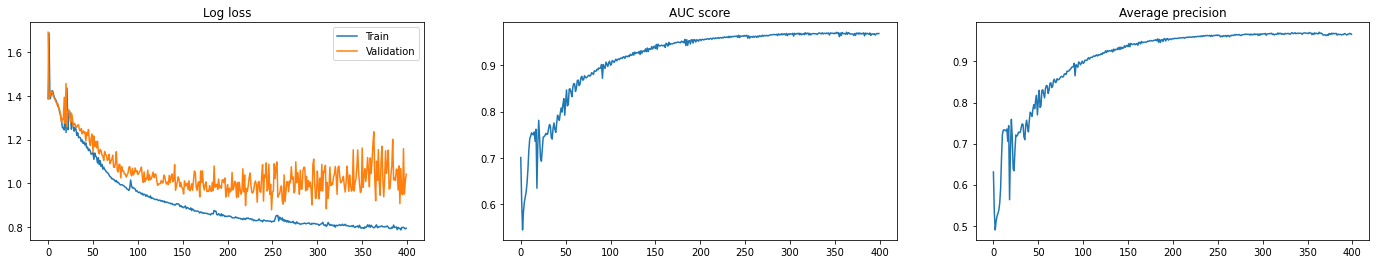

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(24, 4))

ax[0].set_title("Log loss")
ax[0].plot(training_losses, label="Train")
ax[0].plot(validation_losses, label="Validation")
ax[0].legend()

ax[1].set_title("AUC score")
ax[1].plot(val_auc)

ax[2].set_title("Average precision")
ax[2].plot(val_ap)

#### Inspect node embeddings

node embedding을 2D로 만들어 visualization 
(TSNE, UMAP 등 활용)

In [ ]:
embedding = z.cpu().detach().numpy()
embedding

array([[ 0.7156056 , -0.534982  ,  0.9936558 , ...,  1.1040157 ,
         0.3809436 , -0.9132019 ],
       [-0.04620164, -0.5316538 ,  0.29070693, ...,  0.8840478 ,
         0.01533211, -0.310587  ],
       [ 0.06285864,  0.12330243,  0.48000345, ...,  0.3673699 ,
         0.19175944, -0.60429245],
       ...,
       [ 0.02328486, -0.3201539 , -0.41153452, ..., -0.15179744,
        -0.0825803 ,  0.04792397],
       [-0.09035122, -0.27942115, -0.49223933, ..., -0.3385398 ,
        -0.30563924, -0.02779509],
       [ 0.23450795, -0.2547019 , -0.5528482 , ...,  0.12651974,
         0.14301403,  0.02122246]], dtype=float32)

In [ ]:
from openTSNE import TSNE

tsne_embedding = TSNE(exaggeration=2, n_jobs=2).fit(embedding)

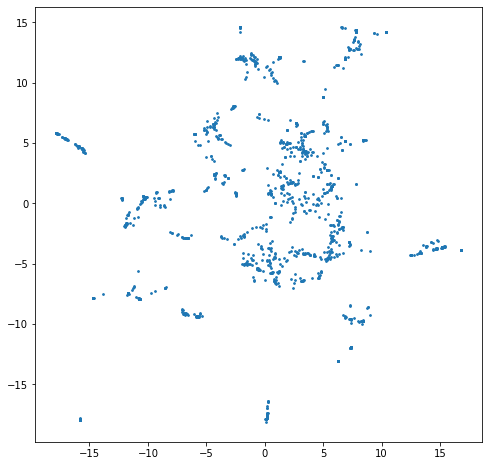

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(tsne_embedding[:, 0], tsne_embedding[:, 1], s=3)